### Libs

In [3]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid

### Dataloader

In [74]:
class Anomaly_Dataset(Dataset):
    def __init__(self,
                 root
                 ):
        super(Anomaly_Dataset, self).__init__()

        self.data = Anomaly_Dataset.load_dataset(root)
        self.image, self.label = Anomaly_Dataset.get_numpy(self.data)

    def __getitem__(self, item):
        x, y =  self.image[item], self.label[item]

        # RGB -> GRAY : (H, W)
        x = x[:,:,0]

        # (1, H, W)
        x = Anomaly_Dataset.normalization(x)
        #x = np.expand_dims(x, axis=0)

        return x, y


    def __len__(self):
        return len(self.data)


    @staticmethod
    def load_dataset(path):
        img_rows = 95
        img_cols = 95
        return image_dataset_from_directory(directory = path,
                                               label_mode = 'int',
                                               color_mode = 'rgb',
                                               shuffle = False,
                                               batch_size = None,
                                               image_size = (img_rows, img_cols),
                                               crop_to_aspect_ratio = True)

    @staticmethod
    def get_numpy(PrefetchDataset):
        """
        return:
            (N, H, W, C) , (N,)
        """
        images = []
        labels = []
        for (image, label) in PrefetchDataset:
            images.append(image)
            labels.append(label)
        return np.array(images), np.array(labels)

    @staticmethod
    def rgb_2_gray(x):
        """
        (H, W, C) --> (H, W)
        """
        return cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

    @staticmethod
    def normalization(x):
        """
        Args:
            x : np.array : (H, W)

        Return:
            np.array : (H, W)
        """
        x = x - x.min(keepdims=True)
        x = x / x.max(keepdims=True)
        x = x - 0.5
        return  x / 0.5

### Noise

In [5]:
def get_noise(num_z, z_dim, device='cpu'):
    # mean, std = 0, 1
    #return torch.empty(num_z, z_dim, 1, 1).normal_(mean, std).to(device)
    return torch.randn(num_z, z_dim, 1, 1, device=device)

### Net

In [75]:
# Change activation to RELU
class Generator(nn.Module):
    def __init__(self, z_dim , c_dim , gf_dim):
        super(Generator, self).__init__()

        # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
        #                          output_padding=0,groups=1, bias=True, dilation=1, padding_mode='zeros')

        self.gen = nn.Sequential(
            Generator._block(z_dim, gf_dim*4, padding=0),
            Generator._block(gf_dim*4, gf_dim*2),
            Generator._block(gf_dim*2, gf_dim*1),
            Generator._block(gf_dim*1, c_dim, final_layer=True),
        )

    def forward(self,inp):
        return self.gen(
            inp
        ) # (c_dim , 215 , 215 )

    @staticmethod
    def _block(in_channels, out_channels, kernel_size=4, stride=3, padding=1, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.Tanh()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace = True)
            )

In [76]:
# TEST
gen = Generator(100, 1, 10)
gen(get_noise(1, 100)).shape

torch.Size([1, 1, 95, 95])

In [83]:
# Change activation to RELU
class Critic(nn.Module):
    def __init__(self , c_dim , df_dim):
        super(Critic, self).__init__()

        # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
        #                          output_padding=0,groups=1, bias=True, dilation=1, padding_mode='zeros')

        self.critic = nn.Sequential(
            Critic._block(c_dim, df_dim),
            Critic._block(df_dim, df_dim*2),
            Critic._block(df_dim*2, df_dim*4),
            Critic._block(df_dim*4, 1, padding=0, final_layer=True),
        )

    def forward(self,inp):
        return self.critic(
            inp
        ).flatten(1) # (N , 1 , 1, 1 )

    @staticmethod
    def _block(in_channels, out_channels, kernel_size=4, stride=3, padding=1, final_layer=False):
        if final_layer:
            return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(negative_slope=0.2)
            )

In [84]:
# TEST
N, C, H, W = 10, 1, 95, 95
x = torch.ones(N, C, H, W)
dis = Critic(C, 10)
dis(x).shape

torch.Size([10, 1])

### Loss

In [85]:
def get_epsilon(N_epsilon, device='cpu'):
    """
    Parameters:
        N_epsilon : Number of epsilons
    Output:
        e.g. shape : (128, 1, 1, 1)
    """
    return torch.rand(N_epsilon, 1, 1, 1, device=device, requires_grad=True)

In [86]:
def get_gradient(crit, data):
    """
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        dis: the critic model
        data: a batch of data
    Returns:
        gradient: the gradient of the discriminator's scores, with respect to data
    """

    # True require_grad of Data
    data.requires_grad_()
    # Calculate the discriminator's scores on the data
    score = crit(data)

    # Take the gradient of the scores with respect to the data
    gradient = torch.autograd.grad(
        inputs=data,
        outputs=score,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(score),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [87]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of data gradients, you calculate the magnitude of each data's gradient
    and penalize the mean quadratic distance of each magnitude to 1.

    Parameters:
        gradient: the gradient of the discriminator's scores, with respect to the data
        e.g shape  : (128, 1, 28, 28)

    Returns:
        penalty: the gradient penalty
        e.g shaoe : (scaler)
    '''

    # Flatten the gradients so that each row captures one image
    # e.g shape  : (128, 1, 28, 28) ==> (128, 784)
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    # e.g shape : (128, 784) ==> (128, 1)
    gradient_norm = gradient.norm(2, dim=1)

    # Penalize the mean squared distance of the gradient norms from 1
    # e.g shape : (128, 1) ==> (scaler)
    penalty = ( ( gradient_norm - 1.0 )**2 ).mean(dim=0)
    return penalty

In [88]:
def get_crit_loss(
    image, z_dim,
    gen, crit,
    c_lambda,
    device):
    '''
    Parameters:
        All as same as DCGAN Losses
    Returns:
        dis_loss: a scalar for the dis's loss
    '''
    #x_no_tumor_fake = gen(x_tumor #+ get_noise(x_tumor, device=device)).detach()

    image_hat = gen(
        get_noise(image.shape[0], z_dim, device=device)
    ).detach()

    # Mixed "real" with "fake"
    #epsilon = get_epsilon(N_epsilon = x_no_tumor.shape[0], device=device)
    epsilon = get_epsilon(N_epsilon = image.shape[0], device=device)

    #mixed_images = x_no_tumor * epsilon + x_no_tumor_fake * (1 - epsilon)
    mixed_images = image * epsilon + image_hat * (1 - epsilon)

    # Calculate Gradient Penalty (use prior funcs)
    gp = gradient_penalty(get_gradient(crit, mixed_images))
    # Calculate "Line 7" of "Algorithm 1" in main paper
    #return ( dis(x_no_tumor_fake) - dis(x_no_tumor) + c_lambda * gp ).mean(dim=0)
    return ( crit(image_hat) - crit(image) + c_lambda * gp ).mean(dim=0)

In [89]:
def get_gen_loss(
      image,z_dim,
      gen, crit,
      device):
    '''
    Return the loss of a generator.
    Parameters:

    Returns:
       a scalar loss value for the current batch of the generator
    '''
    image_hat = gen(
        get_noise(image.shape[0], z_dim, device=device)
    )
    # Calculate "Line 12" of "Algorithm 1" in main paper
    return ( -crit(image_hat) ).mean(dim=0)

### Helper

In [90]:
def ploter(image, image_hat):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,2,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image_hat)
    plt.tight_layout()
    plt.title("Reconstruct")

    plt.subplot(1,2,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image)
    plt.tight_layout()
    plt.title("Original")

    plt.show()

In [91]:
def weights_init(submodules):
    if isinstance(submodules, nn.Conv2d) or isinstance(submodules, nn.ConvTranspose2d):
        torch.nn.init.normal_(submodules.weight, 0.0, 0.02)
    if isinstance(submodules, nn.BatchNorm2d):
        torch.nn.init.normal_(submodules.weight, 0.0, 0.02)
        torch.nn.init.constant_(submodules.bias, 0)

In [92]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 128, 128)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap='gray', vmin=-1, vmax=1)
    plt.show()

### Hyperparamters

In [102]:
z_dim , c_dim , gf_dim = 200, 1, 128
df_dim = 64

device = 'cuda'

batch_size =20


lr_gen, lr_crit = 0.0001, 0.0001
beta_1 = 0.5
beta_2 = 0.999

# epochs
epochs= 5000
disp_freq=1
display_step=5

crit_repeats=5
c_lambda = 10

In [94]:
gen = Generator(z_dim , c_dim , gf_dim).to(device)
crit = Critic(c_dim, df_dim).to(device)

# Initialize
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

# Loss function
#criterion=nn.BCEWithLogitsLoss()

# Optimizers
optim_crit = torch.optim.Adam(crit.parameters(), lr=lr_crit, betas=(beta_1, beta_2))
optim_gen = torch.optim.Adam(gen.parameters(), lr=lr_gen, betas=(beta_1, beta_2))

### Dataset

In [95]:
root = "/content/drive/MyDrive/MRI Arman/kaggle1/no"
dataset = Anomaly_Dataset(root)
dataloader_normal = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Found 98 files belonging to 1 classes.


In [96]:
for x, y in dataloader_normal:
    x=x
    y=y

In [97]:
x.shape

torch.Size([8, 95, 95])

In [98]:
get_noise(100,100).dtype

torch.float32

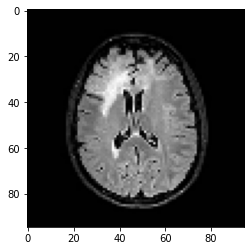

In [99]:
plt.figure()
plt.imshow(x[0], cmap='gray', vmin=-1, vmax=1)

In [100]:
import gc

gc.collect()

torch.cuda.empty_cache()

### Training

In [46]:
epoch

600

In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []

############################################################
###### Epoch 1 #############################################
############################################################
############################################################
###### Epoch 2 #############################################
############################################################
############################################################
###### Epoch 3 #############################################
############################################################
############################################################
###### Epoch 4 #############################################
############################################################
############################################################
###### Epoch 5 #############################################
############################################################
############################################################
###### Epoch 6 #########

<Figure size 432x288 with 0 Axes>

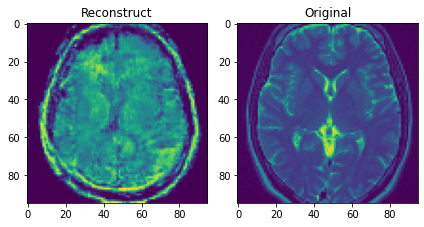

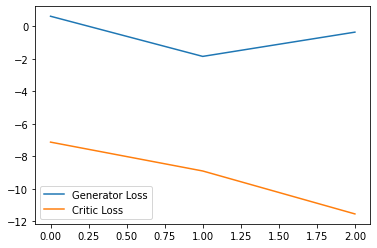

############################################################
###### Epoch 7 #############################################
############################################################
############################################################
###### Epoch 8 #############################################
############################################################
############################################################
###### Epoch 9 #############################################
############################################################
############################################################
###### Epoch 10 #############################################
############################################################
############################################################
###### Epoch 11 #############################################
############################################################
Epoch 11, step 10: Generator loss: 13.54541119337082, critic loss: -41.895435523986

<Figure size 432x288 with 0 Axes>

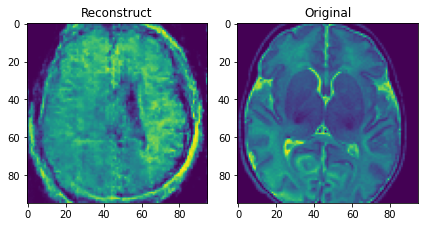

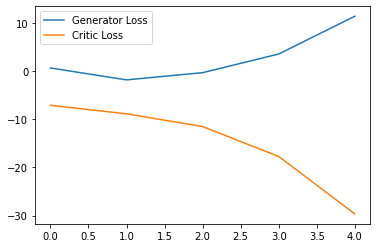

############################################################
###### Epoch 12 #############################################
############################################################
############################################################
###### Epoch 13 #############################################
############################################################
############################################################
###### Epoch 14 #############################################
############################################################
############################################################
###### Epoch 15 #############################################
############################################################
############################################################
###### Epoch 16 #############################################
############################################################
Epoch 16, step 15: Generator loss: 8.015303421020509, critic loss: -1.4564928795

<Figure size 432x288 with 0 Axes>

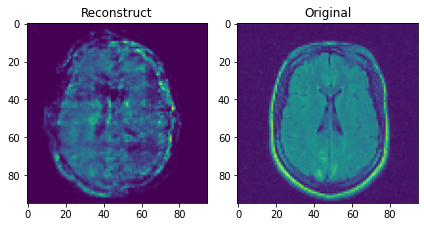

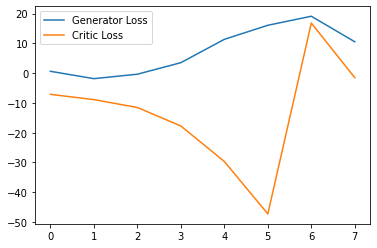

############################################################
###### Epoch 17 #############################################
############################################################
############################################################
###### Epoch 18 #############################################
############################################################
############################################################
###### Epoch 19 #############################################
############################################################
############################################################
###### Epoch 20 #############################################
############################################################
############################################################
###### Epoch 21 #############################################
############################################################
Epoch 21, step 20: Generator loss: 2.6828657150268556, critic loss: -2.406718312

<Figure size 432x288 with 0 Axes>

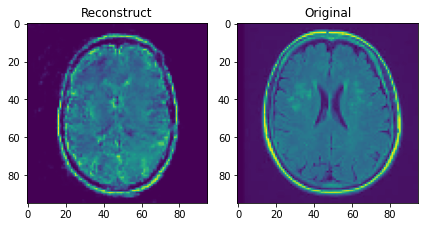

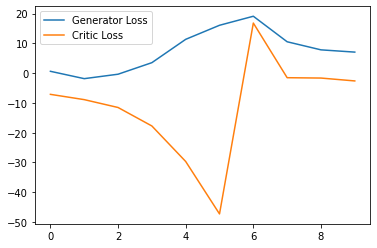

############################################################
###### Epoch 22 #############################################
############################################################
############################################################
###### Epoch 23 #############################################
############################################################
############################################################
###### Epoch 24 #############################################
############################################################
############################################################
###### Epoch 25 #############################################
############################################################
############################################################
###### Epoch 26 #############################################
############################################################
Epoch 26, step 25: Generator loss: -0.25933602452278137, critic loss: -3.6779566

<Figure size 432x288 with 0 Axes>

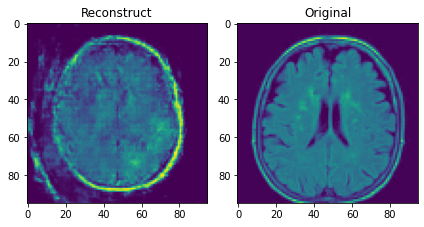

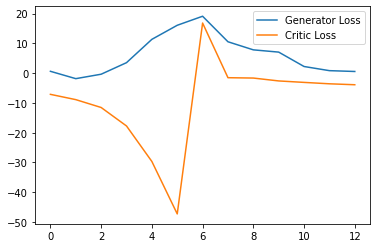

############################################################
###### Epoch 27 #############################################
############################################################
############################################################
###### Epoch 28 #############################################
############################################################
############################################################
###### Epoch 29 #############################################
############################################################
############################################################
###### Epoch 30 #############################################
############################################################
############################################################
###### Epoch 31 #############################################
############################################################
Epoch 31, step 30: Generator loss: -2.5695504188537597, critic loss: -4.75195191

<Figure size 432x288 with 0 Axes>

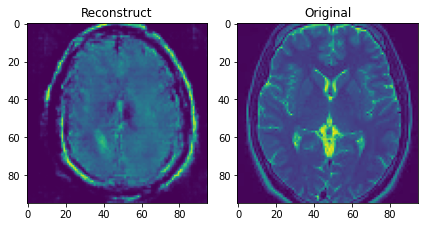

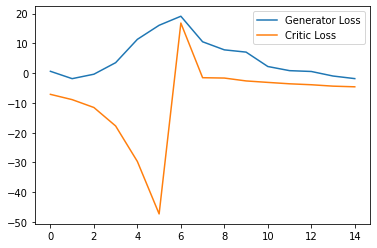

############################################################
###### Epoch 32 #############################################
############################################################
############################################################
###### Epoch 33 #############################################
############################################################
############################################################
###### Epoch 34 #############################################
############################################################
############################################################
###### Epoch 35 #############################################
############################################################
############################################################
###### Epoch 36 #############################################
############################################################
Epoch 36, step 35: Generator loss: -2.551678514480591, critic loss: -7.091650638

<Figure size 432x288 with 0 Axes>

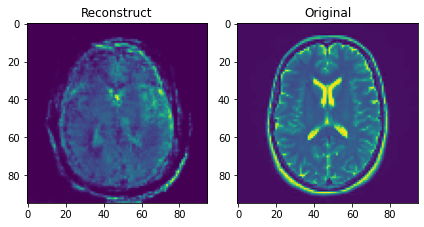

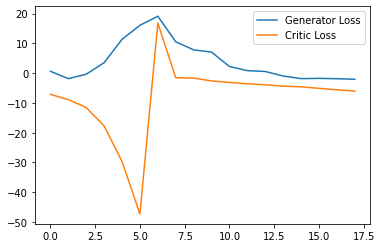

############################################################
###### Epoch 37 #############################################
############################################################
############################################################
###### Epoch 38 #############################################
############################################################
############################################################
###### Epoch 39 #############################################
############################################################
############################################################
###### Epoch 40 #############################################
############################################################
############################################################
###### Epoch 41 #############################################
############################################################
Epoch 41, step 40: Generator loss: -1.7928809583187104, critic loss: -6.76288389

<Figure size 432x288 with 0 Axes>

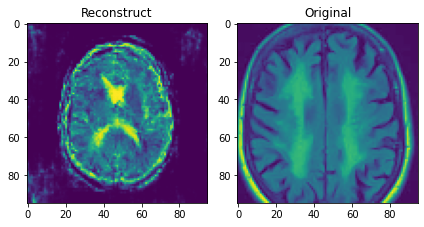

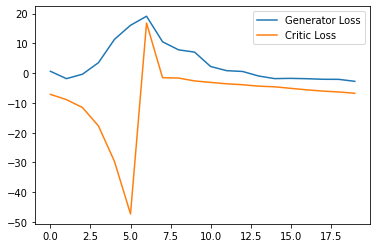

############################################################
###### Epoch 42 #############################################
############################################################
############################################################
###### Epoch 43 #############################################
############################################################
############################################################
###### Epoch 44 #############################################
############################################################
############################################################
###### Epoch 45 #############################################
############################################################
############################################################
###### Epoch 46 #############################################
############################################################
Epoch 46, step 45: Generator loss: -2.383619689941406, critic loss: -7.611766548

<Figure size 432x288 with 0 Axes>

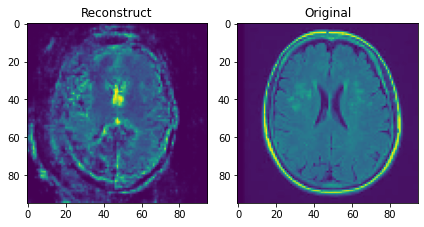

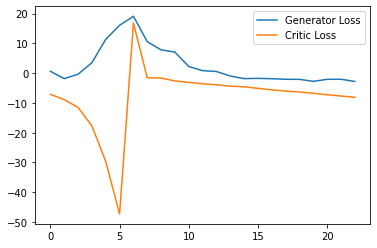

############################################################
###### Epoch 47 #############################################
############################################################
############################################################
###### Epoch 48 #############################################
############################################################
############################################################
###### Epoch 49 #############################################
############################################################
############################################################
###### Epoch 50 #############################################
############################################################
############################################################
###### Epoch 51 #############################################
############################################################
Epoch 51, step 50: Generator loss: -1.425228153169155, critic loss: -8.299943695

<Figure size 432x288 with 0 Axes>

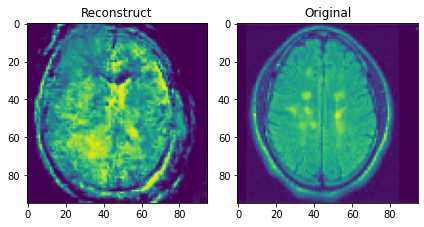

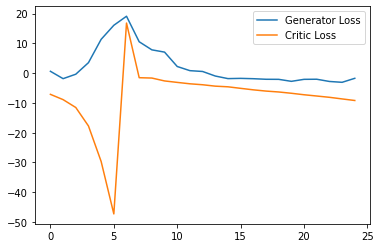

############################################################
###### Epoch 52 #############################################
############################################################
############################################################
###### Epoch 53 #############################################
############################################################
############################################################
###### Epoch 54 #############################################
############################################################
############################################################
###### Epoch 55 #############################################
############################################################
############################################################
###### Epoch 56 #############################################
############################################################
Epoch 56, step 55: Generator loss: 0.7034038782119751, critic loss: -11.35527333

<Figure size 432x288 with 0 Axes>

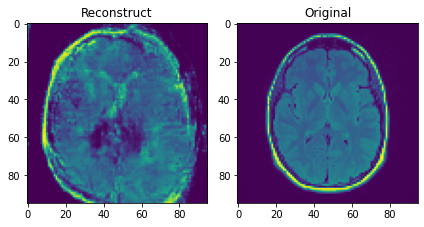

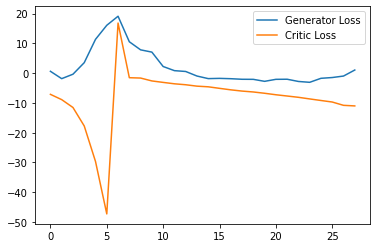

############################################################
###### Epoch 57 #############################################
############################################################
############################################################
###### Epoch 58 #############################################
############################################################
############################################################
###### Epoch 59 #############################################
############################################################
############################################################
###### Epoch 60 #############################################
############################################################
############################################################
###### Epoch 61 #############################################
############################################################
Epoch 61, step 60: Generator loss: 3.5142014980316163, critic loss: -13.62409799

<Figure size 432x288 with 0 Axes>

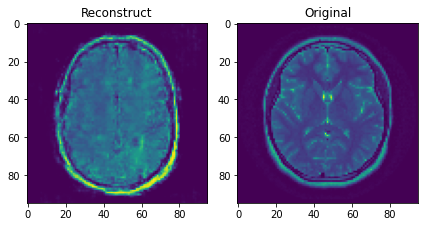

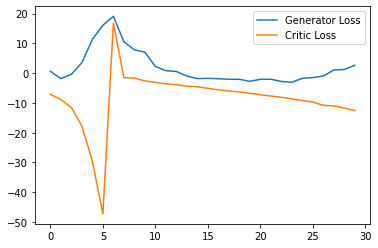

############################################################
###### Epoch 62 #############################################
############################################################
############################################################
###### Epoch 63 #############################################
############################################################
############################################################
###### Epoch 64 #############################################
############################################################
############################################################
###### Epoch 65 #############################################
############################################################


In [ ]:
for epoch in range(1,epochs+1):
    print(60 * "#")
    print(6 * "#" + " Epoch " + str(epoch) + " " + 45 * "#")
    print(60 * "#")

    # Set mode on "train mode"
    gen.train()
    dis.train()

    for image,_ in dataloader_normal:
        cur_batch_size = len(image)
        # GPU (model and data)
        image = image.unsqueeze(1).to(device)

        # Discriminator Learning
        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
          optim_crit.zero_grad()
          crit_loss  = get_crit_loss(image, z_dim, gen, crit, c_lambda, device=device)
          crit_loss .backward(retain_graph=True)
          optim_crit.step()
          mean_iteration_critic_loss += crit_loss.item() / crit_repeats
        critic_losses += [mean_iteration_critic_loss]

        # Generator Learning
        optim_gen.zero_grad()
        gen_loss  = get_gen_loss(image, z_dim, gen, crit, device=device)
        gen_loss .backward()
        optim_gen.step()
        generator_losses += [gen_loss .item()]

    # Save parameters of discriminator and generator
    #save_model(gen, dis, epoch, root_models, mode='colab')
    #print("Loss Dis: {:.2f}\tLoss Gen: {:.2f}".format(loss_dis,loss_gen))

    ### Visualization code ###
    if cur_step % display_step == 0 and cur_step > 0:
        gen_mean = sum(generator_losses[-display_step:]) / display_step
        crit_mean = sum(critic_losses[-display_step:]) / display_step
        print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")



        fake = gen(
            get_noise(image.shape[0], z_dim, device)
        )

        #show_tensor_images(fake)
        #show_tensor_images(image)

        i=math.floor(np.random.uniform(0, image.shape[0]))
        plt.figure()
        ploter(image[i,0].detach().cpu(), fake[i,0].detach().cpu())
        plt.show()

        step_bins = 20
        num_examples = (len(generator_losses) // step_bins) * step_bins
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Generator Loss"
        )
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Critic Loss"
        )
        plt.legend()
        plt.show()
    cur_step += 1

    if epoch % 250 == 0:
      root_save = f"/content/drive/MyDrive/MRI Arman/epoch_{epoch}.pt"
      torch.save({'epoch': epoch, 'Generator': gen.state_dict(), 'Critic': crit.state_dict()},
                  root_save)

In [54]:
epoch

1500

In [53]:
epoch % 250 == 0

True

In [ ]:
z_dim , c_dim , gf_dim = 100, 1, 64
df_dim = 64

device = 'cuda'

batch_size =25


lr_gen, lr_crit = 0.0002, 0.0002
beta_1 = 0.5
beta_2 = 0.999

# epochs
epochs= 300
disp_freq=1
display_step=5

crit_repeats=5
c_lambda = 10

In [51]:
gen.state_dict()

OrderedDict([('gen.0.0.weight',
              tensor([[[[-4.6427e-02,  8.0914e-03, -1.5600e-01,  9.9507e-02,  4.1842e-02],
                        [-2.8644e-01, -2.3766e-02,  7.0591e-02, -8.7372e-02,  8.4534e-02],
                        [-2.9674e-02, -6.2480e-02, -2.6026e-02,  4.9522e-02,  9.2129e-02],
                        [-8.5354e-02, -6.3952e-03, -1.1810e-01, -2.3789e-02,  4.1890e-02],
                        [-4.9541e-01,  4.4973e-02,  1.0884e-01, -2.0160e-01, -9.9095e-02]],
              
                       [[ 1.0877e-03, -3.3872e-02,  1.0536e-01, -1.4502e-01, -1.2249e-01],
                        [ 6.9330e-02,  1.5260e-01, -1.3519e-01, -4.1306e-03, -4.1238e-02],
                        [ 6.2133e-03, -5.0054e-02,  4.7354e-02, -1.4893e-01, -2.3600e-02],
                        [ 5.6317e-02, -8.5436e-02, -1.0941e-01,  2.1778e-01,  7.6771e-02],
                        [-1.9850e-02,  3.0953e-02,  2.1859e-02,  3.7487e-02, -2.4247e-02]],
              
                       [[ 

In [ ]:
image.shape

In [52]:
root_save = f"/content/drive/MyDrive/MRI Arman/kaggle1/epoch_{epoch}.pt"
torch.save({'epoch': epoch, 'Generator': gen.state_dict(), 'Critic': crit.state_dict()},
            root_save)

### Dataset

In [ ]:
root = "./../dataset/kaggle1/no"
dataset = Anomaly_Dataset(root)
dataloader_normal = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for x, y in dataloader_normal:
    x=x
    y=y

In [ ]:
plt.figure()
plt.imshow(x[0], cmap='gray', vmin=-1, vmax=1)

### Training